In [64]:
import pandas as pd
import plotly.express as px
import matplotlib.ticker as ticker
import shap

from sklearn import set_config
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_squared_error, r2_score


set_config(transform_output="pandas")

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
df = pd.read_csv('Final_predictions.csv')

In [65]:
df_building = df.copy()

In [66]:
# Sélectionner les colonnes numériques
numeric_col = df_building.select_dtypes(include=[np.number]).columns

# Afficher les noms des colonnes sélectionnées
print("Variables continue : " ,numeric_col)

Variables continue :  Index(['Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions',
       'BuildingType_NonResidential', 'BuildingType_infrequent_sklearn',
       'PrimaryPropertyType_infrequent_sklearn',
       'ListOfAllPropertyUseTypes_infrequent_sklearn',
       'LargestPropertyUseType_infrequent_sklearn',
       'SecondLargestPropertyUseType_infrequent_sklearn',
       'ThirdLargestPropertyUseType_nan',
       'ThirdLargestPropertyUseType_infrequent_sklearn'],
      dtype='object')


In [67]:
# Sélection des colonnes pour l'entraînement
features = ['Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore',
       'BuildingType_NonResidential', 
       'ThirdLargestPropertyUseType_nan',
     
       ]

# Extraction des features et de la cible
X = df_building[features]
# Remplacer les valeurs manquantes par la moyenne de la variable cible
y = df_building['SiteEnergyUseWN(kBtu)'].fillna(df_building['SiteEnergyUseWN(kBtu)'].mean())

# Split en train et test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## ElasticNet

In [78]:
model = ElasticNet()

# Création du DataFrame vide pour stocker les résultats
results_dfElasticNet = pd.DataFrame(columns=['scoring_name', 'best_score', 'min_test_score', 'min_test_score_time', 'train_scores', 'fit_time', 'split_score'])
param_grid = {
    'alpha': [0.001, 0.01, 0.1],
    'l1_ratio': [0.1, 0.3, 0.5]
}
scorings = {'mse': make_scorer(mean_squared_error), 
            'mape': make_scorer(mean_absolute_percentage_error),
            'r2': make_scorer(r2_score)}


# Boucle sur les mesures de performance
for scoring_name, scoring_func in scorings.items():
    # Initialisation de l'objet GridSearchCV
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scoring_func)

    # Entraînement du modèle sur les données d'entraînement
    grid_search.fit(X_train, y_train)

    # Meilleur score et hyperparamètres pour cette mesure de performance
    best_score = grid_search.best_score_
    
    # Score minimum de test
    min_test_score = grid_search.cv_results_['mean_test_score'][grid_search.cv_results_['rank_test_score'].argmin()]
    
    # Temps correspondant au score minimum de test
    min_test_score_time = grid_search.cv_results_['mean_score_time'][grid_search.cv_results_['rank_test_score'].argmin()]
    
    # Scores d'entraînement pour chaque répétition de validation croisée
    train_scores = grid_search.cv_results_['mean_fit_time']
    
    # Temps d'exécution pour chaque combinaison de paramètre
    fit_time = grid_search.cv_results_['std_fit_time']
    
    # Score pour chaque split de validation croisée
    split_score = grid_search.cv_results_['split0_test_score']
    
    # Ajout des résultats dans le DataFrame
    results_dfElasticNet = results_dfElasticNet.append({
        'scoring_name': scoring_name,
        'best_score': best_score,
        'min_test_score': min_test_score,
        'min_test_score_time': min_test_score_time,
        'train_scores': train_scores,
        'fit_time': fit_time,
        'split_score': split_score
    }, ignore_index=True)

# Affichage des résultats
print(results_dfElasticNet)


  scoring_name    best_score  min_test_score  min_test_score_time  \
0          mse  1.904489e+00    1.904489e+00             0.001800   
1         mape  3.416847e+14    3.416847e+14             0.002201   
2           r2  3.780769e-01    3.780769e-01             0.002200   

                                        train_scores  \
0  [0.006799030303955078, 0.0051994800567626955, ...   
1  [0.006199026107788086, 0.0047992229461669925, ...   
2  [0.006198883056640625, 0.006002092361450195, 0...   

                                            fit_time  \
0  [0.0021364223413214913, 0.00040063917622638813...   
1  [0.0019390842479863688, 0.0007484814706462292,...   
2  [0.0019393202592890737, 0.0014163707435457, 0....   

                                         split_score  
0  [0.82968428281989, 0.8291713045783335, 0.82865...  
1  [0.04412250895281253, 0.04409464155877975, 0.0...  
2  [0.5457485507611635, 0.5460294059183362, 0.546...  


In [84]:
# Prédictions sur les données de test
y_pred = grid_search.predict(X_test)

# Evaluation des performances sur les données de test
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("MAPE: ", mape)
print("R2: ", r2)

MSE:  3.987044328520787
MAPE:  909961077554993.4
R2:  0.12319538288386112


In [69]:
display(results_df)

,scoring_name,best_score,min_test_score,min_test_score_time,train_scores,fit_time,split_score
0,mse,1.904489e+00,1.904489e+00,0.001799,"[0.006198787689208984, 0.005599498748779297, 0...","[0.0007485455047238671, 0.00135658625340827, 0...","[0.82968428281989, 0.8291713045783335, 0.82865..."
1,mape,3.416847e+14,3.416847e+14,0.001599,"[0.005799436569213867, 0.005599069595336914, 0...","[0.0009793560414342562, 0.0018553759769234304,...","[0.04412250895281253, 0.04409464155877975, 0.0..."
2,r2,3.780769e-01,3.780769e-01,0.002200,"[0.00619964599609375, 0.004800224304199218, 0....","[0.0020390534923905193, 0.0007487489314970223,...","[0.5457485507611635, 0.5460294059183362, 0.546..."


In [70]:
grid_search.cv_results_

{'mean_fit_time': array([0.00619888, 0.00719948, 0.00600038, 0.00380039, 0.00419965,
        0.00420041, 0.00299916, 0.00360012, 0.00339975]),
 'std_fit_time': array([0.00097962, 0.00231523, 0.00167303, 0.00040007, 0.00074886,
        0.00098041, 0.00063279, 0.00101993, 0.00080066]),
 'mean_score_time': array([0.00200081, 0.00220022, 0.00220022, 0.00279946, 0.00219955,
        0.00219975, 0.00180049, 0.00280066, 0.00220032]),
 'std_score_time': array([1.26159254e-06, 3.99781553e-04, 4.00853763e-04, 1.16629407e-03,
        3.99399373e-04, 9.79841938e-04, 7.48060751e-04, 1.59993178e-03,
        4.00329612e-04]),
 'param_alpha': masked_array(data=[0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_l1_ratio': masked_array(data=[0.1, 0.3, 0.5, 0.1, 0.3, 0.5, 0.1, 0.3, 0.5],
              mask=[False, False, False, False, Fals

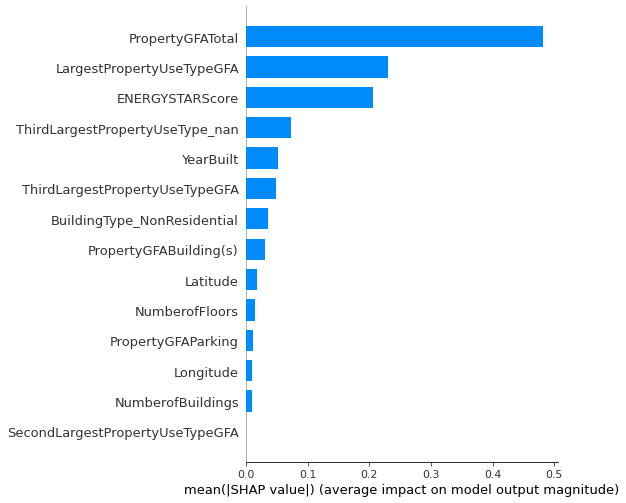

In [61]:
# Création de l'objet Explainer SHAP
explainer = shap.Explainer(grid_search.best_estimator_, X_train)

# Calcul des valeurs SHAP pour la colonne 'ENERGYSTARScore' dans les données d'entraînement
shap_values = explainer(X_train)

# Affichage du graphique SHAP pour la colonne 'ENERGYSTARScore'
#shap.summary_plot(shap_values, feature_names=['ENERGYSTARScore'])
#shap.summary_plot(shap_values, feature_names=['ENERGYSTARScore'], plot_type="bar")
shap.summary_plot(shap_values, X_train,plot_type="bar")

## RandomForest

In [86]:
# Création du DataFrame vide pour stocker les résultats
results_RandomForest = pd.DataFrame(columns=['scoring_name', 'best_score', 'min_test_score', 'min_test_score_time', 'train_scores', 'fit_time', 'split_score'])

# Liste des mesures de performance à tester
scorings = {'mse': make_scorer(mean_squared_error), 
            'mape': make_scorer(mean_absolute_percentage_error),
            'r2': make_scorer(r2_score)}

# Transformer la target variable et entraîner le modèle
rf = RandomForestRegressor()

# Grille de recherche pour les hyperparamètres
params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 10]
}

# Boucle sur les mesures de performance
for scoring_name, scoring_func in scorings.items():
    # Initialisation de l'objet GridSearchCV
    grid_search = GridSearchCV(rf, param_grid=params, cv=5, n_jobs=-1, scoring=scoring_func)

    # Entraînement du modèle sur les données d'entraînement
    grid_search.fit(X_train, y_train)

    # Meilleur score et hyperparamètres pour cette mesure de performance
    best_score = grid_search.best_score_
    
    # Score minimum de test
    min_test_score = grid_search.cv_results_['mean_test_score'][grid_search.cv_results_['rank_test_score'].argmin()]
    
    # Temps correspondant au score minimum de test
    min_test_score_time = grid_search.cv_results_['mean_score_time'][grid_search.cv_results_['rank_test_score'].argmin()]
    
    # Scores d'entraînement pour chaque répétition de validation croisée
    train_scores = grid_search.cv_results_['mean_fit_time']
    
    # Temps d'exécution pour chaque combinaison de paramètre
    fit_time = grid_search.cv_results_['std_fit_time']
    
    # Score pour chaque split de validation croisée
    split_score = grid_search.cv_results_['split0_test_score']
    
    # Ajout des résultats dans le DataFrame
    results_RandomForest = results_RandomForest.append({
        'scoring_name': scoring_name,
        'best_score': best_score,
        'min_test_score': min_test_score,
        'min_test_score_time': min_test_score_time,
        'train_scores': train_scores,
        'fit_time': fit_time,
        'split_score': split_score
    }, ignore_index=True)

# Affichage des résultats
print(results_RandomForest)


  scoring_name    best_score  min_test_score  min_test_score_time  \
0          mse  2.257592e+00    2.257592e+00             0.013067   
1         mape  3.454760e+14    3.454760e+14             0.006201   
2           r2  2.826509e-01    2.826509e-01             0.006201   

                                        train_scores  \
0  [0.219889497756958, 0.38076443672180177, 0.763...   
1  [0.17713146209716796, 0.35161337852478025, 0.7...   
2  [0.18002748489379883, 0.37068676948547363, 0.7...   

                                            fit_time  \
0  [0.020185921794155192, 0.020027701419613735, 0...   
1  [0.0028295147460759393, 0.007710198240891587, ...   
2  [0.007487683346367319, 0.02659227177917003, 0....   

                                         split_score  
0  [1.0839564742410264, 1.0580532953410622, 1.093...  
1  [0.049960868285867786, 0.050729839641045306, 0...  
2  [0.38646837708189496, 0.3778083601832606, 0.39...  


In [87]:
# Prédictions sur les données de test
y_pred = grid_search.predict(X_test)

# Evaluation des performances sur les données de test
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("MAPE: ", mape)
print("R2: ", r2)

MSE:  3.9843050516037133
MAPE:  911926378135734.0
R2:  0.12379778668240149


In [74]:
results_RandomForest

,scoring_nameRF,best_scoreRF,min_test_scoreRF,min_test_score_timeRF,train_scoresRF,fit_timeRF,split_scoreRF
0,mse,2.256041e+00,2.256041e+00,0.008000,"[0.1995974063873291, 0.38379807472229005, 0.80...","[0.012846695749940669, 0.01438601836353122, 0....","[1.1244046305442748, 1.1254345292636847, 1.108..."
1,mape,3.452265e+14,3.452265e+14,0.006401,"[0.19039087295532225, 0.3749989986419678, 0.75...","[0.008574689476174112, 0.0029646734113160456, ...","[0.05003288157311402, 0.0495036576452787, 0.05..."
2,r2,2.868706e-01,2.868706e-01,0.011801,"[0.2275981903076172, 0.4404151439666748, 0.823...","[0.016245245499209377, 0.012476736668885371, 0...","[0.4014384941839886, 0.43539723377168693, 0.41..."


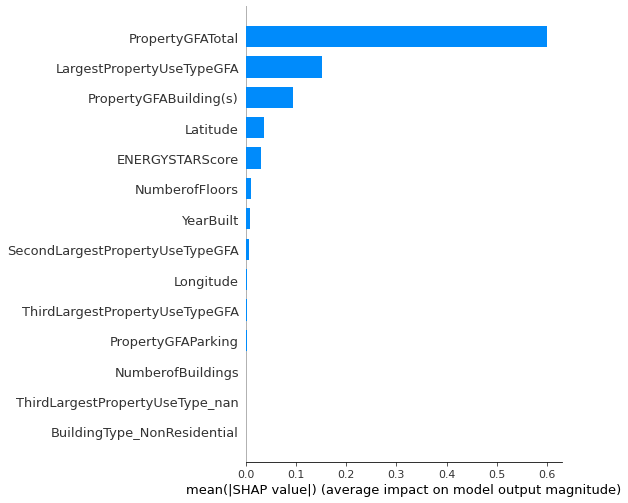

In [75]:
# Création de l'objet Explainer SHAP
explainer = shap.Explainer(grid_search.best_estimator_, X_train)

# Calcul des valeurs SHAP pour la colonne 'ENERGYSTARScore' dans les données d'entraînement
shap_values = explainer(X_train)

# Affichage du graphique SHAP pour la colonne 'ENERGYSTARScore'
#shap.summary_plot(shap_values, feature_names=['ENERGYSTARScore'])
#shap.summary_plot(shap_values, feature_names=['ENERGYSTARScore'], plot_type="bar")
shap.summary_plot(shap_values, X_train,plot_type="bar")

## Gradient Boosing

In [88]:
results_GradientBoosting = pd.DataFrame(columns=['scoring_name', 'best_score', 'min_test_score', 'min_test_score_time', 'train_scores', 'fit_time', 'split_score'])

# Liste des mesures de performance à tester
scorings = {'mse': make_scorer(mean_squared_error), 
            'mape': make_scorer(mean_absolute_percentage_error),
            'r2': make_scorer(r2_score)}
# Configuration des hyperparamètres
params = {
    "learning_rate": [0.001,0.01,0.1],
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 10]
}
scoring_namesgb = []
best_scoresgb = []

# Instanciation du modèle
gb = GradientBoostingRegressor()

# Boucle sur les mesures de performance
for scoring_name, scoring_func in scorings.items():
    # Initialisation de l'objet GridSearchCV
    grid_search = GridSearchCV(gb, param_grid=params, cv=5, n_jobs=-1, scoring=scoring_func)

    # Entraînement du modèle sur les données d'entraînement
    grid_search.fit(X_train, y_train)
 # Meilleur score et hyperparamètres pour cette mesure de performance
    best_score = grid_search.best_score_
    
    # Score minimum de test
    min_test_score = grid_search.cv_results_['mean_test_score'][grid_search.cv_results_['rank_test_score'].argmin()]
    
    # Temps correspondant au score minimum de test
    min_test_score_time = grid_search.cv_results_['mean_score_time'][grid_search.cv_results_['rank_test_score'].argmin()]
    
    # Scores d'entraînement pour chaque répétition de validation croisée
    train_scores = grid_search.cv_results_['mean_fit_time']
    
    # Temps d'exécution pour chaque combinaison de paramètre
    fit_time = grid_search.cv_results_['std_fit_time']
    
    # Score pour chaque split de validation croisée
    split_score = grid_search.cv_results_['split0_test_score']
    
    # Ajout des résultats dans le DataFrame
    results_GradientBoosting = results_GradientBoosting.append({
        'scoring_name': scoring_name,
        'best_score': best_score,
        'min_test_score': min_test_score,
        'min_test_score_time': min_test_score_time,
        'train_scores': train_scores,
        'fit_time': fit_time,
        'split_score': split_score
    }, ignore_index=True)

# Affichage des résultats
print(results_GradientBoosting)


  scoring_name    best_score  min_test_score  min_test_score_time  \
0          mse  3.004810e+00    3.004810e+00             0.003799   
1         mape  3.488058e+14    3.488058e+14             0.003200   
2           r2  2.922709e-01    2.922709e-01             0.003801   

                                        train_scores  \
0  [0.2356274127960205, 0.4486110687255859, 0.989...   
1  [0.19882302284240722, 0.4049959659576416, 0.78...   
2  [0.20139923095703124, 0.3958895683288574, 0.78...   

                                            fit_time  \
0  [0.02077625358914576, 0.025657276085702847, 0....   
1  [0.0031648752860563003, 0.017290204964645943, ...   
2  [0.004029501873546777, 0.00944619388220591, 0....   

                                         split_score  
0  [1.759315105369492, 1.6922188282886068, 1.5822...  
1  [0.0707220772311351, 0.06899441831283386, 0.06...  
2  [0.03677645481521774, 0.0735116102636656, 0.13...  


In [89]:
# Prédictions sur les données de test
y_pred = grid_search.predict(X_test)

# Evaluation des performances sur les données de test
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("MAPE: ", mape)
print("R2: ", r2)

MSE:  3.9318942506068058
MAPE:  906525514712718.0
R2:  0.1353236260045575


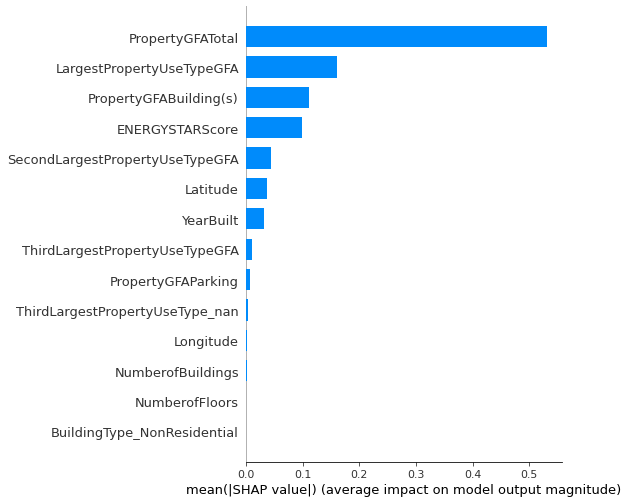

In [77]:
# Création de l'objet Explainer SHAP
explainer = shap.Explainer(grid_search.best_estimator_, X_train)

# Calcul des valeurs SHAP pour la colonne 'ENERGYSTARScore' dans les données d'entraînement
shap_values = explainer(X_train)

# Affichage du graphique SHAP pour la colonne 'ENERGYSTARScore'
#shap.summary_plot(shap_values, feature_names=['ENERGYSTARScore'])
#shap.summary_plot(shap_values, feature_names=['ENERGYSTARScore'], plot_type="bar")
shap.summary_plot(shap_values, X_train,plot_type="bar")

In [82]:
# Créer un dictionnaire de tableaux de scores pour chaque modèle
scores_dict = {
    'Elastic Net': results_dfElasticNet,
    'Random Forest': results_RandomForest,
    'Gradient Boosting': results_GradientBoosting
}

# Concaténer les tableaux de scores en un seul tableau
scores_df = pd.concat(scores_dict.values(), keys=scores_dict.keys())

# Nommer l'index et les colonnes
scores_df.index.names = ['Model', 'Metric']


In [83]:
scores_df

scoring_name    best_score  min_test_score  \
Model             Metric                                              
Elastic Net       0               mse  1.904489e+00    1.904489e+00   
                  1              mape  3.416847e+14    3.416847e+14   
                  2                r2  3.780769e-01    3.780769e-01   
Random Forest     0               mse  2.259051e+00    2.259051e+00   
                  1              mape  3.458476e+14    3.458476e+14   
                  2                r2  2.739037e-01    2.739037e-01   
Gradient Boosting 0               mse  3.084811e+00    3.084811e+00   
                  1              mape  3.482870e+14    3.482870e+14   
                  2                r2  2.923556e-01    2.923556e-01   

                          min_test_score_time  \
Model             Metric                        
Elastic Net       0                  0.001800   
                  1                  0.002201   
                  2                  0.002200   
Random Forest     0                  0.014400   
                  1                  0.024000   
                  2                  0.018000   
Gradient Boosting 0                  0.005199   
                  1                  0.003201   
                  2                  0.003000   

                                                               train_scores  \
Model             Metric                                                      
Elastic Net       0       [0.006799030303955078, 0.0051994800567626955, ...   
                  1       [0.006199026107788086, 0.0047992229461669925, ...   
                  2       [0.006198883056640625, 0.006002092361450195, 0...   
Random Forest     0       [0.1809981346130371, 0.44179983139038087, 0.76...   
                  1       [0.2201986312866211, 0.5117998600006104, 0.738...   
                  2       [0.20879898071289063, 0.5485998153686523, 0.95...   
Gradient Boosting 0       [0.2185986042022705, 0.43939971923828125, 0.93...   
                  1       [0.2463973045349121, 0.45759878158569334, 0.90...   
                  2       [0.2027909755706787, 0.4081986904144287, 0.795...   

                                                                   fit_time  \
Model             Metric                                                      
Elastic Net       0       [0.0021364223413214913, 0.00040063917622638813...   
                  1       [0.0019390842479863688, 0.0007484814706462292,...   
                  2       [0.0019393202592890737, 0.0014163707435457, 0....   
Random Forest     0       [0.006229960007089794, 0.04162900627410367, 0....   
                  1       [0.01325767605423025, 0.040720663744590574, 0....   
                  2       [0.02392806840838811, 0.03894888930330247, 0.1...   
Gradient Boosting 0       [0.010891861414866233, 0.013603473780191163, 0...   
                  1       [0.013514695346913347, 0.03561246624032466, 0....   
                  2       [0.011518793408529614, 0.01334786118623783, 0....   

                                                                split_score  
Model             Metric                                                     
Elastic Net       0       [0.82968428281989, 0.8291713045783335, 0.82865...  
                  1       [0.04412250895281253, 0.04409464155877975, 0.0...  
                  2       [0.5457485507611635, 0.5460294059183362, 0.546...  
Random Forest     0       [1.047796403190643, 1.0678425755218057, 1.0934...  
                  1       [0.05071967245488481, 0.05058747574615913, 0.0...  
                  2       [0.4039115003852678, 0.399271465574742, 0.4253...  
Gradient Boosting 0       [1.759315105369492, 1.6922188282886068, 1.5822...  
                  1       [0.0707220772311351, 0.06899441831283386, 0.06...  
                  2       [0.03677645481521774, 0.0735116102636656, 0.13...